# MAGPRIME Tutorial notebook
This notebook provides a hands-on tutorial for using the MAGPRIME Python library to clean and process magnetometer data. MAGPRIME implements several state-of-the-art algorithms for removing noise and interference from magnetometer measurements.

In this tutorial, we will cover:

* Loading sample magnetometer data from the QSZ-1 Japanese GNSS Satellite.
* Visualizing and assessing the raw data
* Preprocessing steps like detrending, filtering, etc.
* Applying MAGPRIME's noise removal algorithms:
    * Independent Component Analysis (ICA)
    * Multivariate Singular Spectrum Analysis (MSSA)
    * Gradiometry 
    * Principal Component Gradiometry
    * SHEINKER
    * Frequency-Based Gradiometry
    * Underdetermined Blind Source Separation (UBSS)
    * Wavelet-Adaptive Interference Cancellation for Underdetermined Platforms (WAIC-UP)
* Comparing noise removal performance

The goal is to demonstrate a typical workflow using MAGPRIME to clean real-world magnetometer data. The noise removal methods in MAGPRIME were designed to handle issues like sensor noise, environmental interference, and more. By the end of this tutorial you should have a good understanding of how to leverage MAGPRIME for your own projects.

Let's get started!

### Load data from Michibiki-1 Magnetometers
In this notebook, we will use noisy magnetometer data from the [Michibiki-1 satellite](https://sees.tksc.jaxa.jp/fw/dfw/SEES/English/Papers/data/2020/peer_reviewed/01/2020_reviewed_01.shtml). This data is featured in Imajo et al. (2021) to showcase the use of ICA to clean magnetometer data. 

The code first imports NumPy for numerical processing and Matplotlib for plotting. It then loads the raw biased Michibiki-1 magnetometer data from a .dat file into a matrix called B_qzs. The known bias values are subtracted from each sensor axis to center the signals around zero.

Since some algorithms like UBSS and MSSA are computationally intensive, the data is decimated to 0.1 Hz to speed up processing.

Matplotlib is used to create a figure with two columns of subplots to visualize the data. The left column overlays the readings from the two magnetometer sensors MAM-S1 and MAM-S2 for each axis. The right column plots the difference between the sensors.

This plot shows the noisy nature of the data, with interference patterns clearly visible. The sensor disagreement is also apparent in the difference plots.

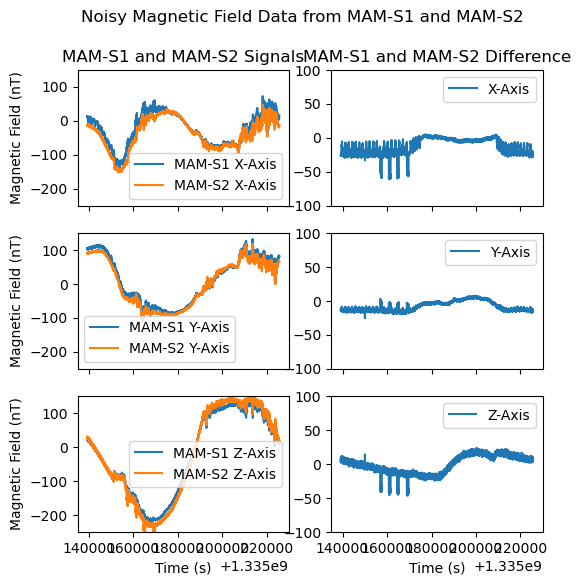

In [5]:
"Import the necessary modules"
import numpy as np
import matplotlib.pyplot as plt

"Import the magnetometer data from the file"
qzs_1 = np.loadtxt(r"examples\SPACE_DATA\michibiki.dat", dtype=np.float, usecols=(0,4,5,6,7,8,9))
B_qzs = qzs_1.T

"Subtract the bias from the magnetometer data"
B_qzs[1] -= 60 # MAM-S1 X-Axis
B_qzs[2] -= 410 # MAM-S1 Y-Axis
B_qzs[3] -= -202 # MAM-S1 Z-Axis
B_qzs[4] -= -528 # MAM-S2 X-Axis
B_qzs[5] -= -200 # MAM-S2 Y-Axis
B_qzs[6] -= 478 # MAM-S2 Z-Axis

"Decimate the data to 0.1 Hz because UBSS and MSSA are slow methods and it will take a long time to run on 86,400 data points"
B_qzs = B_qzs[:,::10]

"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(6, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B_qzs[0], B_qzs[1], label="MAM-S1 X-Axis")
axs[0,0].plot(B_qzs[0], B_qzs[4], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B_qzs[0], B_qzs[2], label="MAM-S1 Y-Axis")
axs[1,0].plot(B_qzs[0], B_qzs[5], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B_qzs[0], B_qzs[3], label="MAM-S1 Z-Axis")
axs[2,0].plot(B_qzs[0], B_qzs[6], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B_qzs[0], B_qzs[4]-B_qzs[1], label="X-Axis")
axs[0,1].legend()
axs[0,1].set_ylim(-100, 100)

axs[1,1].plot(B_qzs[0], B_qzs[5]-B_qzs[2], label="Y-Axis")
axs[1,1].legend()
axs[1,1].set_ylim(-100, 100)

axs[2,1].plot(B_qzs[0], B_qzs[6]-B_qzs[3], label="Z-Axis")
axs[2,1].set_ylim(-100, 100)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()



### Magnetometer data formatting

MAGPRIME expects magnetometer data to be in a 3D array with shape (n_sensors, n_axes, n_samples). This allows it to handle an arbitrary number of vector sensors, with each sensor providing a time series for 3 orthogonal axes.

The Michibiki-1 data has 2 sensors - MAM-S1 and MAM-S2. So, we need to rearrange the time series loaded from the file into a (2, 3, n_samples) array.

The code below stacks the x, y, z axes for each sensor using NumPy's vstack. Then it stacks the sensor arrays into a 3D array using np.stack. Printing the shape confirms it is now (2, 3, 8640) for 2 sensors, 3 axes, and 8640 samples. This properly formats the data for passing to MAGPRIME's Magnetometer class and algorithms.

In [6]:
"Rearrange B into (n_sensors, n_axes, n_samples)"
B1 = np.vstack((B_qzs[1], B_qzs[2], B_qzs[3]))
B2 = np.vstack((B_qzs[4], B_qzs[5], B_qzs[6]))
B = np.stack((B1, B2))
print(B.shape)

(2, 3, 8640)


### Independent Component Analysis
Independent Component Analysis (ICA) is a blind source separation method that leverages the statistical independence of signals to separate the true geomagnetic field from noise sources in magnetometer data. It first detrends and preprocesses the data. The ICA algorithm then decomposes the data into independent components. To identify the natural magnetic field, it selects the ICs that have the lowest correlation with the difference between sensors, under the assumption ambient fields produce consistent signals. These ICs are used to reconstruct the denoised data. 

A summary of each algorithm and its parameters can be seen through calling

`help(algorithm)`

In [13]:
help(ICA)

Help on module magprime.ICA in magprime:

NAME
    magprime.ICA

DESCRIPTION
    Author: Shun Imajo, Alex Hoffmann
    Last Update: 9/19/2023
    Description: This file implements a noise removal method using independent component
                 analysis (ICA) for magnetic field data from multiple magnetometers. 
                 The method follows the approach of Imajo et al. (2021). The method 
                 separates the noise components from the signal components based on 
                 their statistical independence and non-Gaussianity. The natural magnetic 
                 field components are then identified by their similarity in the mixing
                 matrix (ica.mixing_).
                 
    General Parameters
    ----------
    uf : window size for uniform filter used to detrend the data
    detrend : boolean for whether to detrend the data

FUNCTIONS
    clean(B, triaxial=True)
        B: magnetic field measurements from the sensor array (n_sensors, axes, n_

Help on module magprime.ICA in magprime:

NAME
    magprime.ICA

DESCRIPTION
    Author: Shun Imajo, Alex Hoffmann
    Last Update: 9/19/2023
    Description: This file implements a noise removal method using independent component
                 analysis (ICA) for magnetic field data from multiple magnetometers. 
                 The method follows the approach of Imajo et al. (2021). The method 
                 separates the noise components from the signal components based on 
                 their statistical independence and non-Gaussianity. The natural magnetic 
                 field components are then identified by their similarity in the mixing
                 matrix (ica.mixing_).
                 
    General Parameters
    ----------
    uf : window size for uniform filter used to detrend the data
    detrend : boolean for whether to detrend the data

FUNCTIONS
    clean(B, triaxial=True)
        B: magnetic field measurements from the sensor array (n_sensors, axes, n_

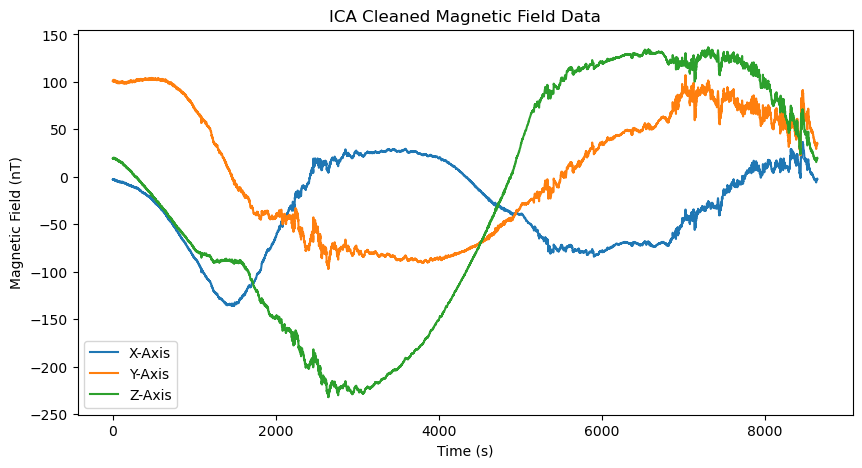

In [7]:
from magprime import ICA

"Set Detrend to True and Uniform Filter Size used to remove the DC component"
ICA.detrend = True
ICA.uf = 360

"Clean the data"
B_ica = ICA.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.title("ICA Cleaned Magnetic Field Data")
plt.plot(B_ica[0], label="X-Axis")
plt.plot(B_ica[1], label="Y-Axis")
plt.plot(B_ica[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()
plt.show()


### Frequency-based Gradiometry (Ream et al. 2021)
Todo: Explanation

Help on module magprime.REAM in magprime:

NAME
    magprime.REAM

DESCRIPTION
    Author: Alex Hoffmann
    Last Update: 9/19/2023
    Description: 
                 
    General Parameters
    ----------
    uf : window size for uniform filter used to detrend the data
    detrend : boolean for whether to detrend the data
    
    Algorithm Parameters
    ----------
    delta_B : threshold for the change in the differenced field envelope (nT)
    n : number of time steps for the change in the envelope
    p : percentile threshold for identifying spectral peaks (0-100)

FUNCTIONS
    clean(B, triaxial=True)
        Perform magnetic gradiometry using frequency-domain filtering
        Input:
            B: magnetic field measurements from the sensor array (n_sensors, axes, n_samples)
        Output:
            result: reconstructed ambient field without the spacecraft-generated fields (axes, n_samples)
    
    gradiometry_filter(B1, B2)
        Perform magnetic gradiometry using frequ

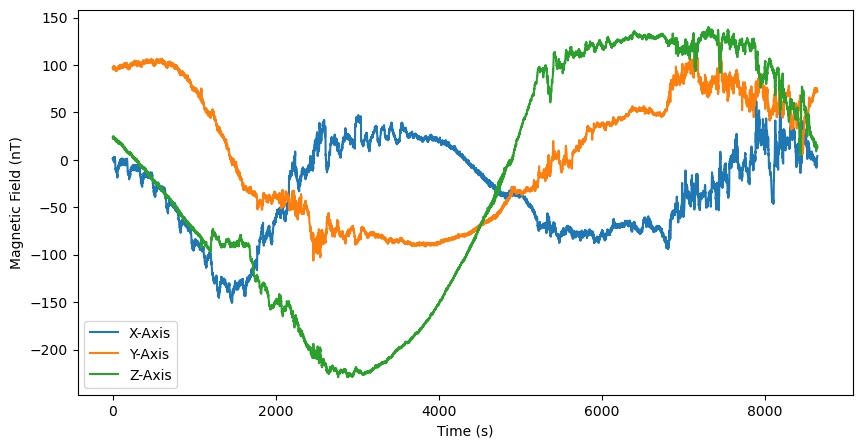

In [8]:
from magprime import REAM

"Detrend the data"
REAM.detrend = True
REAM.uf = 360

"Algorithm Parameters"
REAM.delta_B = 3
REAM.n = 20
REAM.p = 98

"Clean the data"
B_ream = REAM.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_ream[0], label="X-Axis")
plt.plot(B_ream[1], label="Y-Axis")
plt.plot(B_ream[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()

### SHEINKER
Todo Explanation

Help on module magprime.SHEINKER in magprime:

NAME
    magprime.SHEINKER

DESCRIPTION
    Author: Arie Sheinker, Alex Hoffmann
    Last Update: 9/19/2023
    Description: Todo
    
    General Parameters
    ----------
    uf : window size for uniform filter used to detrend the data
    detrend : boolean for whether to detrend the data

FUNCTIONS
    clean(B, triaxial=True)
        B: magnetic field measurements from the sensor array (n_sensors, axes, n_samples)
        triaxial: boolean for whether to use triaxial or uniaxial ICA
    
    cleanSheinker(sig)

DATA
    detrend = False
    uf = 400

FILE
    c:\users\alexp\onedrive\documents\github\magprime\magprime\sheinker.py




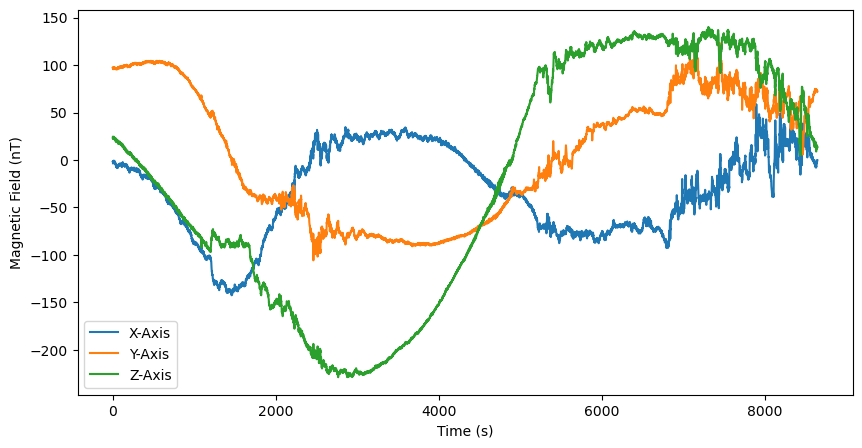

In [9]:
from magprime import SHEINKER

"Detrend the data"
SHEINKER.uf = 360
SHEINKER.detrend = True

"Clean the data"
B_sheinker = SHEINKER.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_sheinker[0], label="X-Axis")
plt.plot(B_sheinker[1], label="Y-Axis")
plt.plot(B_sheinker[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()


### Principal Component Gradiometry (PiCoG)

Help on module magprime.PiCoG in magprime:

NAME
    magprime.PiCoG

DESCRIPTION
    Author: XYZ, Alex Hoffmann
    Last Update: 9/19/2023
    Description: Todo
    
    General Parameters
    ----------
    uf : window size for uniform filter used to detrend the data
    detrend : boolean for whether to detrend the data

FUNCTIONS
    clean(B, triaxial=True)
        Perform Principal Component gradiometry PCA on the magnetic field data
        Input:
            B: magnetic field measurements from the sensor array (n_sensors, axes, n_samples)
        Output:
            result: reconstructed ambient field without the spacecraft-generated fields (axes, n_samples)
    
    clean_first_order(B)
    
    clean_higher_order(B, order=2)
    
    rotate_data(data, vector)
        Rotate the data such that the X axis aligns with the provided vector.
        Input:
            data: array of tri-axial data with shape (axes, samples)
            vector: array specifying the vector direction wit

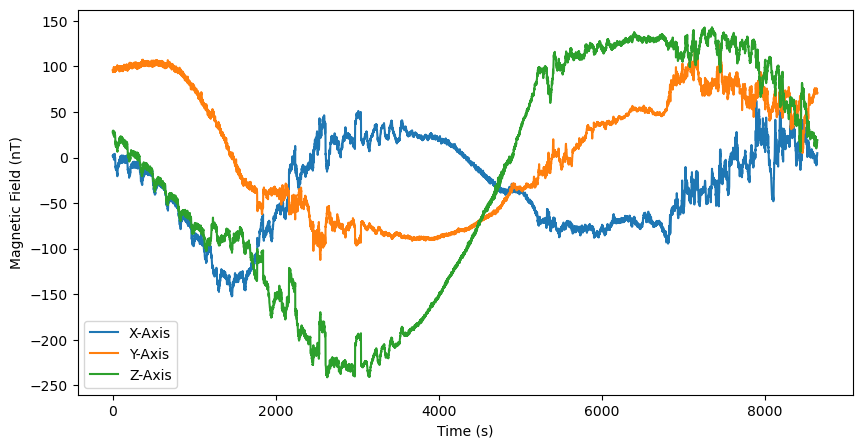

In [10]:
from magprime import PiCoG

"Detrend the data"
PiCoG.uf = 360
PiCoG.detrend = True

"Clean the data"
B_picog = PiCoG.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_picog[0], label="X-Axis")
plt.plot(B_picog[1], label="Y-Axis")
plt.plot(B_picog[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()



### WAIC-UP 
Todo Explanation
(Hoffmann and Moldwin, 2023)

Help on module magprime.WAICUP in magprime:

NAME
    magprime.WAICUP

DESCRIPTION
    Author: Alex Hoffmann
    Last Update: 9/19/2023
    Description: Todo
    
    General Parameters
    ----------
    uf : window size for uniform filter used to detrend the data
    detrend : boolean for whether to detrend the data
    
    Algorithm Parameters
    ----------
    fs : sampling frequency
    dj : wavelet scale spacing
    scales : scales used in the wavelet transform (set by the algorithm)

FUNCTIONS
    clean(B, triaxial=True)
        B: magnetic field measurements from the sensor array (n_sensors, axes, n_samples)
        triaxial: boolean for whether to use triaxial or uniaxial ICA
    
    cleanWAICUP(sensors)
    
    dual(sig, dt, dj)
        Create Wavelets
    
    multi(sig, dt, dj)
        Find Combinations

DATA
    detrend = False
    dj = 0.08333333333333333
    fs = 1
    scales = None
    uf = 400

FILE
    c:\users\alexp\onedrive\documents\github\magprime\magprime\wai

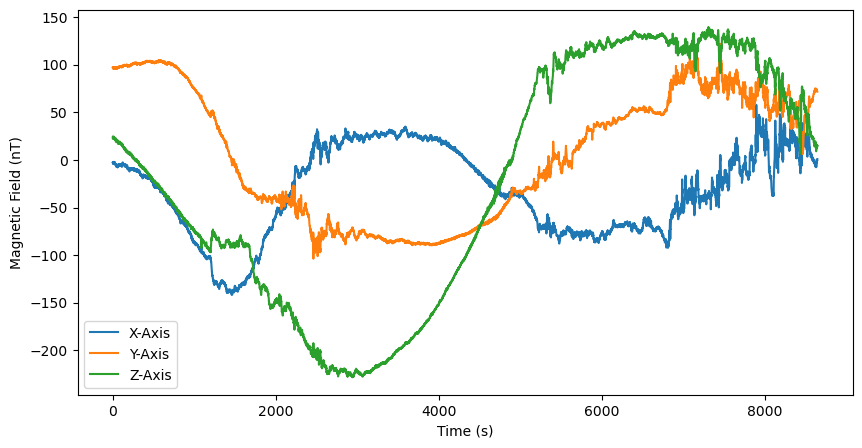

In [11]:
from magprime import WAICUP

"Detrend the data"
WAICUP.uf = 360
WAICUP.detrend = True

"Algorithm Parameters"
WAICUP.fs = .1
WAICUP.dj = 1/12

"Clean the data"
B_waicup = WAICUP.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_waicup[0], label="X-Axis")
plt.plot(B_waicup[1], label="Y-Axis")
plt.plot(B_waicup[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()


### Multichannel Singular Spectrum Analysis
Todo Explanation

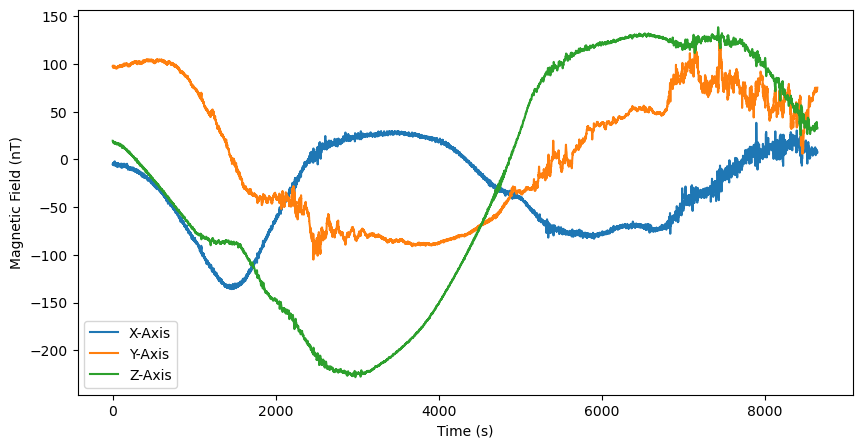

In [18]:
from magprime import MSSA

"Detrend the data"
MSSA.uf = 360
MSSA.detrend = True

"Algorithm Parameters"
MSSA.window_size = 360
MSSA.alpha = 0.05


"Clean the data"
B_mssa = MSSA.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_mssa[0], label="X-Axis")
plt.plot(B_mssa[1], label="Y-Axis")
plt.plot(B_mssa[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()

### Underdetermined Blind Source Separation
Todo Explanation

100%|██████████| 8947/8947 [01:53<00:00, 78.68it/s]


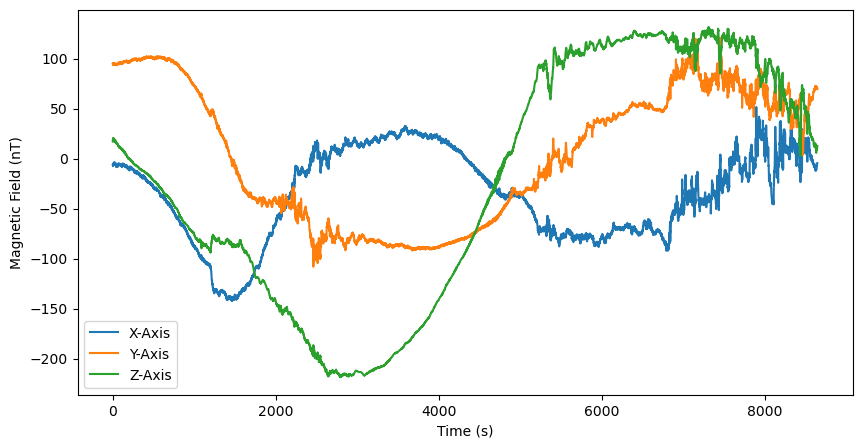

In [30]:
from magprime import UBSS

"Detrend the data"
UBSS.detrend = False

"Algorithm Parameters"
UBSS.sigma = 10
UBSS.fs = .1
UBSS.lowf = 2*UBSS.Q*UBSS.fs/(B.shape[-1])

"Clean the data"
B_ubss = UBSS.clean(np.copy(B), triaxial=True)

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_ubss[0], label="X-Axis")
plt.plot(B_ubss[1], label="Y-Axis")
plt.plot(B_ubss[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()



### Metrics

In [26]:
"Todo"

Help on module magprime.REAM in magprime:

NAME
    magprime.REAM

FUNCTIONS
    clean(B, triaxial=True)
        Perform magnetic gradiometry using frequency-domain filtering
        Input:
            B: magnetic field measurements from the sensor array (n_sensors, axes, n_samples)
        Output:
            result: reconstructed ambient field without the spacecraft-generated fields (axes, n_samples)
    
    gradiometry_filter(B1, B2)
        Perform magnetic gradiometry using frequency-domain filtering
        Input:
            B1: magnetic field measurements from the inboard sensor
            B2: magnetic field measurements from the outboard sensor
        Output:
            B_amb: reconstructed ambient field without the spacecraft-generated fields

DATA
    __warningregistry__ = {'version': 101}
    delta_B = 3
    n = 20
    p = 98

FILE
    c:\users\alexp\onedrive\documents\github\magprime\magprime\ream.py


